In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm

In [17]:
# Force equal aspect ratio for 3D plot
def set_axes_equal(ax):
    """Set 3D plot axes to equal scale (so x, y, z are equally scaled)."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range])
    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim3d([mid_x - max_range/2, mid_x + max_range/2])
    ax.set_ylim3d([mid_y - max_range/2, mid_y + max_range/2])
    ax.set_zlim3d([mid_z - max_range/2, mid_z + max_range/2])


In [18]:
EPS = 1e-9

def unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / (n + 1e-15)

def face_normal_from_verts(verts):
    """Outward normal assuming verts are CCW when seen from OUTSIDE."""
    v0, v1, v2 = np.asarray(verts[0]), np.asarray(verts[1]), np.asarray(verts[2])
    n = np.cross(v1 - v0, v2 - v0)
    return unit(n)

def build_venlo_multispan_simple(n_bays=4, bay_span=8.0, length_L=40.0,
                                 wall_z=3.2, ridge_z=6.2,
                                 include_end_walls=True, include_end_triangles=True):
    """
    Simplified Venlo multi-span geometry (no vents/truss lines).
    * Gutters are at wall_z (no gutter_z parameter).
    * End walls: rectangular base + triangular gable panels per bay.
    Returns list of faces: {'id','p0','n','verts'} with verts CCW from outside.
    Coordinates: z up, x across span, y along length.
    """
    L = length_L
    half = (n_bays * bay_span) / 2.0
    yS, yN = -L/2.0, +L/2.0

    faces = []

    # Side walls at x = ±half
    xW, xE = -half, +half
    west_wall = [
        np.array([xW, yS, 0.0]),
        np.array([xW, yS, wall_z]),
        np.array([xW, yN, wall_z]),
        np.array([xW, yN, 0.0]),
    ]
    east_wall = [
        np.array([xE, yS, 0.0]),
        np.array([xE, yN, 0.0]),
        np.array([xE, yN, wall_z]),
        np.array([xE, yS, wall_z]),
    ]
    for fid, verts in [('wall_WEST', west_wall), ('wall_EAST', east_wall)]:
        faces.append({'id': fid, 'p0': verts[0], 'n': face_normal_from_verts(verts), 'verts': verts})

    # End walls: rectangular lower part (across all bays)
    if include_end_walls:
        endS_rect = [
            np.array([xW, yS, 0.0]),
            np.array([xE, yS, 0.0]),
            np.array([xE, yS, wall_z]),
            np.array([xW, yS, wall_z]),
        ]
        endN_rect = [
            np.array([xE, yN, 0.0]),
            np.array([xW, yN, 0.0]),
            np.array([xW, yN, wall_z]),
            np.array([xE, yN, wall_z]),
        ]
        faces.append({'id':'end_S_rect', 'p0':endS_rect[0], 'n':face_normal_from_verts(endS_rect), 'verts':endS_rect})
        faces.append({'id':'end_N_rect', 'p0':endN_rect[0], 'n':face_normal_from_verts(endN_rect), 'verts':endN_rect})

    # Roof panes & triangular end gables per bay
    for k in range(n_bays):
        x_left  = -half + k*bay_span
        x_right = -half + (k+1)*bay_span
        x_center = 0.5*(x_left + x_right)

        # Left roof pane (gutter/wall top -> ridge)
        roof_L = [
            np.array([x_left,  yS, wall_z]),
            np.array([x_center,yS, ridge_z]),
            np.array([x_center,yN, ridge_z]),
            np.array([x_left,  yN, wall_z]),
        ]
        faces.append({'id': f'roof_k{k}_L', 'p0': roof_L[0], 'n': face_normal_from_verts(roof_L), 'verts': roof_L})

        # Right roof pane (ridge -> gutter/wall top)
        roof_R = [
            np.array([x_center, yS, ridge_z]),
            np.array([x_right,  yS, wall_z]),
            np.array([x_right,  yN, wall_z]),
            np.array([x_center, yN, ridge_z]),
        ]
        faces.append({'id': f'roof_k{k}_R', 'p0': roof_R[0], 'n': face_normal_from_verts(roof_R), 'verts': roof_R})

        # End-wall triangular gables per bay (front/back panels)
        if include_end_walls and include_end_triangles:
            # South end (outside is at -y): CCW as seen from south
            triS = [
                np.array([x_left,  yS, wall_z]),
                np.array([x_right, yS, wall_z]),
                np.array([x_center,yS, ridge_z]),
            ]
            # North end (outside at +y): CCW as seen from north
            triN = [
                np.array([x_right, yN, wall_z]),
                np.array([x_left,  yN, wall_z]),
                np.array([x_center,yN, ridge_z]),
            ]
            faces.append({'id': f'end_S_tri_k{k}', 'p0': triS[0], 'n': face_normal_from_verts(triS), 'verts': triS})
            faces.append({'id': f'end_N_tri_k{k}', 'p0': triN[0], 'n': face_normal_from_verts(triN), 'verts': triN})

    return faces

def plot_greenhouse_simple(faces, rays=None, show_normals=True, view_elev=28, view_azim=-60, figsize=(8,6)):
    colors = cm.tab20(np.linspace(0, 1, len(faces)))
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Faces
    for i, F in enumerate(faces):
        verts = [np.array(v) for v in F['verts']]
        poly = Poly3DCollection([verts], alpha=0.25, facecolor=colors[i], edgecolor='k')
        ax.add_collection3d(poly)

    # Normals
    if show_normals:
        for F in faces:
            verts = np.array(F['verts'])
            centroid = verts.mean(axis=0)
            n = F['n']
            ax.quiver(centroid[0], centroid[1], centroid[2], n[0], n[1], n[2], length=2, normalize=True)

    # Rays
    if rays:
        for R in rays:
            o = np.asarray(R['o'], float)
            d_from_sun = unit(R['d_from_sun'])
            L = float(R.get('L', 30.0))
            p_end = o + L*d_from_sun
            ax.plot([o[0], p_end[0]], [o[1], p_end[1]], [o[2], p_end[2]])

    all_pts = np.vstack([np.array(F['verts']) for F in faces])
    mn = all_pts.min(axis=0) - 1.0
    mx = all_pts.max(axis=0) + 1.0
    ax.set_xlim(mn[0], mx[0])
    ax.set_ylim(mn[1], mx[1])
    ax.set_zlim(mn[2], mx[2])

    ax.set_xlabel('x (span)')
    ax.set_ylabel('y (length)')
    ax.set_zlabel('z (height)')
    ax.view_init(elev=view_elev, azim=view_azim)
    plt.tight_layout()
    set_axes_equal(ax)
    plt.show()


In [19]:
import numpy as np

# ---- 1) Sun direction from azimuth (alpha) and elevation (beta) ----
# Left-handed coordinates: x=transverse, y=longitudinal, z=vertical
# 要確認; 太陽のazimuthとrow coordinateの関係
def sun_dir_from_alpha_beta(azm_sun_row_coord, beta):
    alpha = float(azm_sun_row_coord)
    beta = float(beta)
    cosb, sinb = np.cos(beta), np.sin(beta)
    sina, cosa = np.sin(alpha), np.cos(alpha)
    # Unit vector FROM the point TOWARD the sun
    return np.array([cosb * sina,  # +x when alpha=90°
                     cosb * cosa,  # +y when alpha=0
                     sinb])        # +z for solar elevation


def inside_convex_poly(p, V, n, eps=1e-9):
    """
    Robust inside test for a convex 3D polygon lying in plane with normal n.
    Works for either CW or CCW vertex order.
    """
    sign0 = 0.0
    for i in range(len(V)):
        vi  = V[i]
        vip = V[(i+1) % len(V)]
        s = np.dot(np.cross(vip - vi, p - vi), n)  # signed wrt n
        if abs(s) <= eps:
            continue  # on/near edge; accept and keep going
        if sign0 == 0.0:
            sign0 = np.sign(s)   # set reference sign
        elif s * sign0 < -eps:
            return False         # found an edge with opposite sign → outside
    return True

EPS = 1e-9

# ---- 3) Ray tracing: all cover hits ----
def ray_all_cover_hits(o, d, faces, max_hits=10, eps=1e-6):
    """
    Trace ray through greenhouse surfaces.
    Returns list of (face, t, p) for all intersections in order.
    Stops after max_hits or when no further intersections.
    """
    hits = []
    pos = np.asarray(o, float)
    dir = d / (np.linalg.norm(d) + 1e-15)

    for _ in range(max_hits):
        best = None
        t_min = np.inf
        for F in faces:
            p0, n, V = F['p0'], F['n'], F['verts']
            denom = np.dot(n, dir)
            if abs(denom) < eps:
                continue
            t = np.dot(n, (p0 - pos)) / denom
            if t <= eps:
                continue
            p = pos + t * dir
            if inside_convex_poly(p, V, n, eps=eps) and t < t_min:
                t_min = t
                best = (F, t, p)

        if best is None:
            break  # ray escaped
        F, t, p = best
        hits.append((F, t, p))
        # Move slightly past intersection to avoid self-hitting
        pos = p + dir * eps

    return hits

def ppfd_direct_multi(o, azm_sun_row_coord, beta, faces, Q_dir_out, tau_func):
    """
    Trace sunlight (from Sun to point) through greenhouse covers.
    - Uses correct direction (sun → point)
    - Prints ordered face hits (outermost → innermost)
    - Optionally visualizes
    """
    d_from_sun = sun_dir_from_alpha_beta(azm_sun_row_coord, beta)
    hits = ray_all_cover_hits(o, d_from_sun, faces)
    if not hits:
        print("Ray escapes the greenhouse without hitting any face.")
        print(f"PPFD at point: {Q_dir_out:.6f}")
        return float(Q_dir_out)

    Q = Q_dir_out
    for F, t, p_hit in hits:
        n = F['n']
        cos_theta = abs(np.dot(n, d_from_sun))
        if cos_theta <= 0:  # grazing or backside
            continue
        theta = np.arccos(cos_theta)
        tau = tau_func(theta)
        Q *= tau  # multiply transmission at each hit
        print(f"Ray hits face: {F['id']}")
        print(f"Intersection point (x, y, z): {np.round(p_hit, 6)}")
        print(f"   Incidence angle: {np.degrees(theta):.2f}°, τ={tau:.4f}, cumulative PPFD={Q:.4f}")

    print(f"\nPPFD at point: {Q:.6f}")

    return Q


# ---- 4) Example transmittance functions ----
def tau_constant(theta_rad, tau0=0.82):
    return tau0

def tau_cosine_path(theta_rad, tau0=0.90):
    cos_theta = max(1e-6, np.cos(theta_rad))
    return tau0 ** (1.0 / cos_theta)

def tau_cosine_power(theta_rad, tau0=0.956, m =0.216):
    return tau0 * np.cos(theta_rad)**m

In [20]:
def visualize_ray_hits(faces, point_xyz, azm_sun_row_coord, beta,
                       view_elev=25, view_azim=-60, L=80.0, max_hits=10):
    """
    Visualize a ray from point_xyz toward the sun, showing all intersections.
    """
    point = np.asarray(point_xyz, float)
    # d_to_sun = unit(sun_dir_from_alpha_beta(azm_sun_row_coord, beta))
    d_from_sun = unit(sun_dir_from_alpha_beta(azm_sun_row_coord, beta))


    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # --- Greenhouse geometry ---
    colors = cm.tab20(np.linspace(0, 1, len(faces)))
    for i, F in enumerate(faces):
        verts = [np.array(v) for v in F['verts']]
        poly = Poly3DCollection([verts], alpha=0.35,
                                facecolor=colors[i], edgecolor='k')
        ax.add_collection3d(poly)

    # --- Trace ray through greenhouse ---
    hits = ray_all_cover_hits(point, d_from_sun, faces, max_hits=max_hits)
    pos = point.copy()
    if hits:
        for j, (F, t, p_hit) in enumerate(hits):
            # draw segment up to hit
            ax.plot([pos[0], p_hit[0]], [pos[1], p_hit[1]], [pos[2], p_hit[2]],
                    'r-', linewidth=2)
            ax.scatter(*p_hit, color='blue', s=15)
            ax.text(p_hit[0], p_hit[1], p_hit[2]+0.3,
                    f"{j+1}:{F['id']}", fontsize=8)
            pos = p_hit  # move to new starting point
        # draw remaining line after last hit
        p_end = pos + L * d_from_sun
        ax.plot([pos[0], p_end[0]], [pos[1], p_end[1]], [pos[2], p_end[2]],
                'r--', linewidth=1.2)
    else:
        # no hit case
        p_end = point + L * d_from_sun
        ax.plot([point[0], p_end[0]], [point[1], p_end[1]], [point[2], p_end[2]],
                'r-', linewidth=2, label='Ray (no hit)')

    # --- Origin marker ---
    ax.scatter(*point, color='orange', s=25, label='Origin')

    # --- Axis formatting ---
    ax.set_xlabel('x (span)')
    ax.set_ylabel('y (length)')
    ax.set_zlabel('z (height)')
    ax.set_zlim(bottom=0)
    ax.view_init(elev=view_elev, azim=view_azim)
    try:
        ax.set_box_aspect((1,1,1))
    except Exception:
        set_axes_equal(ax)
    set_axes_equal(ax)
    ax.legend()
    plt.tight_layout()
    plt.show()



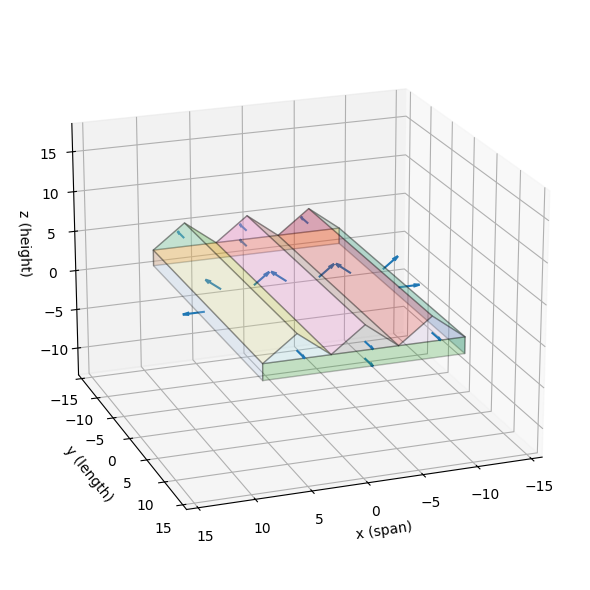

Ray hits face: roof_k0_R
Intersection point (x, y, z): [ -4.683013 -10.         3.683013]
   Incidence angle: 75.00°, τ=0.7139, cumulative PPFD=856.7346

PPFD at point: 856.734635
PPFD at point (multi-hit): 856.7346345165739


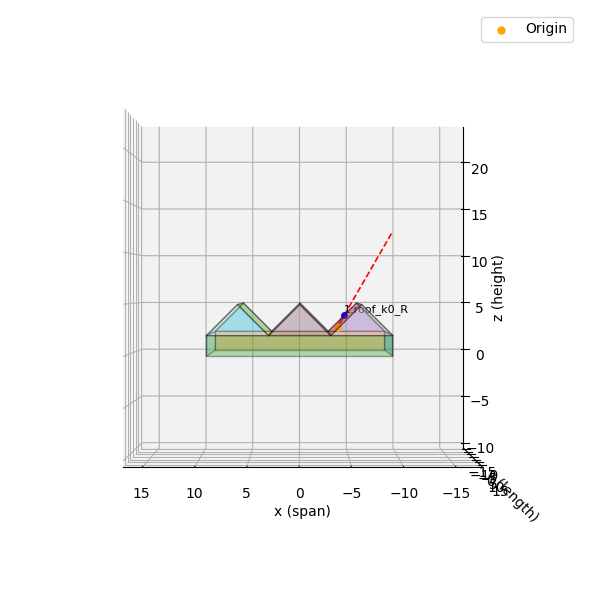

In [22]:
n_bays = 3 # number of bays; 棟の数
bay_span = 6  # m; 一つの棟の幅
length_L = 30.0  # m; 温室の長さ; L_row + 2*L_margin
wall_z = 2  # m; 壁の高さ
ridge_z = 5  # m; 棟の高さ
tau_0 = 0.956  # normal incidence transmittance; 被覆資材に対して垂直に入射したときの透過率
m_parameter = 0.216  # empirical parameter for angular dependence of transmittance

faces = build_venlo_multispan_simple(n_bays=n_bays, bay_span=bay_span, length_L=length_L,
                                     wall_z=wall_z, ridge_z=ridge_z,
                                     include_end_walls=True, include_end_triangles=True)
plot_greenhouse_simple(faces, view_elev=20, view_azim=70, show_normals=True)


point = [-4, -10, 2.5]
azm_sun_row_coord = 90 * np.pi / 180  # azm_sun_row_coord  # radians
beta = 120 * np.pi / 180     # radians
Qb_ext = 1200.0             # external direct PPFD

Q_point_multi = ppfd_direct_multi(
    o=point,
    azm_sun_row_coord=azm_sun_row_coord,
    beta=beta,
    faces=faces,
    Q_dir_out=Qb_ext,
    tau_func=lambda th: tau_cosine_power(th, tau0=tau_0, m=m_parameter)
)

print("PPFD at point (multi-hit):", Q_point_multi)

view_elev = 0
view_azim = 90

visualize_ray_hits(faces, point, azm_sun_row_coord, beta,
                   view_elev=view_elev, view_azim=view_azim, L = 10.0, max_hits=10)